# Forecasting the EUR exchange rate in relation to GBP with RNN's

## Notes about Data

In this short project, I will analyze data obtained from the [European Central Bank](https://www.ecb.europa.eu/stats/policy_and_exchange_rates/euro_reference_exchange_rates/html/eurofxref-graph-gbp.en.html)

For Copyright information, please see the [ECB Terms of Service](https://www.ecb.europa.eu/services/using-our-site/disclaimer/html/index.en.html)

# Workflow

I will be using the following worflow throughout this notebook

0. [Frame the Problem](#section0)


1. [Get the Data](#section1)

2. [Inspect and Clean the Data](#section2)

<ul>

<li> Data Types </li>
<li> Investigate Missing Dates </li>
 
</ul> 

3. [Split the Data](#section3)

4. [Explore the Data](#section4)

<ul>

<li> Investigate Global Patterns </li>
<li> Investigate weekly seasonality</li>
<li> Investigate yearly seasonality </li>

</ul>


5. [ARMA model - Baseline](#section5)

<ul>

<li> ARIMA </li>

</ul>

6. [Prepare Data for RNN's](#section6)

7. [RNN-based models](#section7)

8. [Fine-Tune Best Model](#section8)

9. [Internal Validation](#section9)

10. [External Validation](#section10)

<a class="anchor" id='section0'></a>

# 0. Frame the problem 

The aim of this analysis, is to predict the exchange rate of the the Euro with respect to the GBP. As such, I will analyze historical data provided by the European Central Bank website. The data analyzed here consists of 6408 exchange rate entries between the 4th of January 1999 and the 9th of January 2025.. New data can be obtained by accessing the .xml file provided on the website, subject to terms and conditions for use of the data. The aim of this short project is to find a reliable model that predicts the exchange rate of the EUR with low error. Hence, in this project I will compare various approached :

<ul>

1. Naive predictions
2. ARMA-familly statistical models
3. RNN models

</ul>

<a class="anchor" id='section1'></a>


# 1. Get the Data

Historical data is provided via an xml file. By inspecting the file, we can notice the data is in the "Obs" elements, each such element consisting of several attributes. We are interested in the day of the exchange value  <TIME_PERIOD> and the exchange value itself <OBS_VALUE>. WE can use the namespace to identify the correct tag in the XML file, from which all observation can be extracted via the findall method. Then, it is simply a matter of storing them into a list and converting the list into a dataframe. 

In [1]:
##import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
##parse the document
import xml.etree.ElementTree as ET
tree = ET.parse('/Users/andreibleahu/Documents/Data Science - Personal Projects/ECB Data/GBP_EUR.xml')
root = tree.getroot()

In [3]:

## define the namespace
ns = {'exr': 'http://www.ecb.europa.eu/vocabulary/stats/exr/1'}

# find all observed rates in the namespace
obs_elements = root.findall('.//exr:Obs', ns)

## intialize and empty list to store the data
data = []

## iterate through each observed rate and append the data to the list
for obs in obs_elements:
    date = obs.get('TIME_PERIOD')
    rate = obs.get('OBS_VALUE')
    data.append((date, rate))

## convert the list to a datagrame
gbp = pd.DataFrame(data, columns=['Date', 'Exchange_Rate'])

## convert the 'Date' column to datetime
gbp['Date'] = pd.to_datetime(gbp['Date'])

## convert the 'Exchange_Rate' column to float
gbp['Exchange_Rate'] = gbp['Exchange_Rate'].astype(float)

print(gbp)

           Date  Exchange_Rate
0    1999-01-04        0.71110
1    1999-01-05        0.71220
2    1999-01-06        0.70760
3    1999-01-07        0.70585
4    1999-01-08        0.70940
...         ...            ...
6403 2024-01-03        0.86470
6404 2024-01-04        0.86278
6405 2024-01-05        0.86210
6406 2024-01-08        0.86150
6407 2024-01-09        0.85938

[6408 rows x 2 columns]


In [4]:
gbp

,Date,Exchange_Rate
0,1999-01-04,0.71110
1,1999-01-05,0.71220
2,1999-01-06,0.70760
3,1999-01-07,0.70585
4,1999-01-08,0.70940
...,...,...
6403,2024-01-03,0.86470
6404,2024-01-04,0.86278
6405,2024-01-05,0.86210
6406,2024-01-08,0.86150


We have 6408 rows of data representing the exchange rates of euros to the great britain pound. To put this data into perspective, it is worth looking at the evolution of the gross domestic product (GDP) of great britain during the same period. In contrast to Great Britain, the boundaries of the EU have expanded significantly in the last 25 years, hence looking at the GDP of the EU would reflect a changing economy. In addition, the EUR is not used throughout the European Union, and countries implemented it at different points in time. This is the reason why looking at GDP for the UK might give better insights into the exchange fluctuations of the pound.

<p>

Gross domestic product data has been obtained from the [Office for National Statistics](https://www.ons.gov.uk/economy/grossdomesticproductgdp/datasets/contributionstomonthlygdp)

</p>


In [5]:
gross_domestic_product = pd.read_csv('/Users/andreibleahu/Documents/Data Science - Personal Projects/ECB Data/UK_GDP.csv', sep=',')

In [6]:
gross_domestic_product

,Unnamed: 0,GDP,Per Capita,Growth
0,date,GDP ( Billions of US $),Per Capita (US $),Annual % Change
1,1960-12-31,73.233970838233,1397.5949,NaN
2,1961-12-31,77.741969043148,1472.3858,2.6771
3,1962-12-31,81.247567647219,1525.7759,1.1029
4,1963-12-31,86.561965531025,1613.457,4.8744
...,...,...,...,...
59,2018-12-31,2878.1521473158,43306.3083,1.705
60,2019-12-31,2857.057847953,42747.0805,1.6043
61,2020-12-31,2704.6091600882,40318.4169,-11.0309
62,2021-12-31,3122.4803459245,46585.8976,7.5975


Observe :

- There is GDP data for 63 years ( each data is collected for one year, on the last day of that year)
- there is GDP, GDP per capita and annual change data
- Since it is important to understand how GDP influences the pound, is it better to keep the annual change of the data rather than the actual numbers (Growth)

In [7]:
## rename the columns
gross_domestic_product.columns 

Index(['Unnamed: 0', ' GDP', ' Per Capita', ' Growth'], dtype='object')

In [8]:
gross_domestic_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   64 non-null     object
 1    GDP         64 non-null     object
 2    Per Capita  64 non-null     object
 3    Growth      63 non-null     object
dtypes: object(4)
memory usage: 2.1+ KB


In [9]:
gross_domestic_product = gross_domestic_product.rename(columns={'Unnamed: 0': 'Date', ' GDP': 'GDP', ' Growth' : 'GDP_Growth'})

In [10]:
gross_domestic_product

,Date,GDP,Per Capita,GDP_Growth
0,date,GDP ( Billions of US $),Per Capita (US $),Annual % Change
1,1960-12-31,73.233970838233,1397.5949,NaN
2,1961-12-31,77.741969043148,1472.3858,2.6771
3,1962-12-31,81.247567647219,1525.7759,1.1029
4,1963-12-31,86.561965531025,1613.457,4.8744
...,...,...,...,...
59,2018-12-31,2878.1521473158,43306.3083,1.705
60,2019-12-31,2857.057847953,42747.0805,1.6043
61,2020-12-31,2704.6091600882,40318.4169,-11.0309
62,2021-12-31,3122.4803459245,46585.8976,7.5975


It becomes clear that row 0 simmply reiterates the information in the header of each column - there is no need to keep this

In [11]:
gross_domestic_product = gross_domestic_product.drop(gross_domestic_product.index[0])

In [12]:
gross_domestic_product

,Date,GDP,Per Capita,GDP_Growth
1,1960-12-31,73.233970838233,1397.5949,NaN
2,1961-12-31,77.741969043148,1472.3858,2.6771
3,1962-12-31,81.247567647219,1525.7759,1.1029
4,1963-12-31,86.561965531025,1613.457,4.8744
5,1964-12-31,94.407562406909,1748.2882,5.5337
...,...,...,...,...
59,2018-12-31,2878.1521473158,43306.3083,1.705
60,2019-12-31,2857.057847953,42747.0805,1.6043
61,2020-12-31,2704.6091600882,40318.4169,-11.0309
62,2021-12-31,3122.4803459245,46585.8976,7.5975


<a class="anchor" id='section2'></a>


# 2. Inspect and Clean the Data

## Data types

Let's quickly look over the data types, check for missing values and make sure all exchange rates make sense.

In [13]:
gbp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6408 entries, 0 to 6407
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           6408 non-null   datetime64[ns]
 1   Exchange_Rate  6408 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 100.3 KB


Observe:

- the data contains 6408 entries and no nulls (mising values)
- the values are recorded from the 4th of January 1999 to today ( over 25 years of data)
- as of today, 9th of January 2024, the maximum recorded exchange rate is 0.9785 while the minimum exchange rate is 0.5711
- the frequency of the data is daily (new values are recorded on a daily basis, although not necessarily every day by judging from the number of entries and number of days between these years)




This is very clean and easy to understand data. All that is left to do is to make sure it is chronologically ordered by sorting the data by date, after making "Date" the index of the time series. Then, we can check for missing dates, to see on which days during the 1999-2024 period there was no recorded information.

## Investigate Missing Dates


In [14]:
##sort by first entry day and sets the index to be the date column
gbp_sorted = gbp.sort_values(by='Date', ascending=True).set_index('Date') 

In [15]:
##view the first 5 rows of the dataframe
gbp_sorted.head()

,Exchange_Rate
Date,
1999-01-04,0.71110
1999-01-05,0.71220
1999-01-06,0.70760
1999-01-07,0.70585
1999-01-08,0.70940


In [16]:
##view the last 10 rows of the dataframe
gbp_sorted.tail(10)

,Exchange_Rate
Date,
2023-12-22,0.86660
2023-12-27,0.86830
2023-12-28,0.87060
2023-12-29,0.86905
2024-01-02,0.86645
2024-01-03,0.86470
2024-01-04,0.86278
2024-01-05,0.86210
2024-01-08,0.86150


Observe: 

- The frequency is 'daily' but not all days are accounted for. Looking at the last few entries, there is no data for the 6th and 7th of January for example

In [17]:
##create a new date range with the end points of the original dataframe
all_dates = pd.date_range(start=gbp_sorted.index.min(), end=gbp_sorted.index.max())
all_dates

DatetimeIndex(['1999-01-04', '1999-01-05', '1999-01-06', '1999-01-07',
               '1999-01-08', '1999-01-09', '1999-01-10', '1999-01-11',
               '1999-01-12', '1999-01-13',
               ...
               '2023-12-31', '2024-01-01', '2024-01-02', '2024-01-03',
               '2024-01-04', '2024-01-05', '2024-01-06', '2024-01-07',
               '2024-01-08', '2024-01-09'],
              dtype='datetime64[ns]', length=9137, freq='D')

In [18]:
##find all the missing dates
missing_dates = all_dates.difference(gbp_sorted.index)

In [19]:
##look at the dataframe containing the missing dates
missing_dates
print(f"Data is missing on {len(missing_dates)} days")
print(f"Data is missing in the interval {missing_dates.min()} - {missing_dates.max()}")


Data is missing on 2729 days
Data is missing in the interval 1999-01-09 00:00:00 - 2024-01-07 00:00:00


Observe:

- the 6408 observations (rows) are for days between the 4th of January 1999 and the 9th of July 2024. In this interval, we do not have data for 2729 days
- this doesn't affect the reliability of our data ( there are no missing values in the current dataframe) but simply puts it in perspective : we now know that GBP exchange rate information for some days

In [20]:
##let's have a look at the missing dates
missing_dates

DatetimeIndex(['1999-01-09', '1999-01-10', '1999-01-16', '1999-01-17',
               '1999-01-23', '1999-01-24', '1999-01-30', '1999-01-31',
               '1999-02-06', '1999-02-07',
               ...
               '2023-12-17', '2023-12-23', '2023-12-24', '2023-12-25',
               '2023-12-26', '2023-12-30', '2023-12-31', '2024-01-01',
               '2024-01-06', '2024-01-07'],
              dtype='datetime64[ns]', length=2729, freq=None)

In [21]:
##create a new dataframe with all the dates and mark them as 0
all_dates_encoded = pd.DataFrame(0, index=all_dates, columns=['Exchange_Rate']) 
##set the values of the dates that are present in the original dataframe to 1
all_dates_encoded.loc[gbp_sorted.index] = 1
##let's do a sanity check to understand if all days are accounted for
all_dates_encoded['Exchange_Rate'].value_counts()

Exchange_Rate
1    6408
0    2729
Name: count, dtype: int64

In the above, I created a dataframe that marks clearly if the exchnage rate is present for every day between 1999-01-04 and 2024-01-09. If there is data on the exchange value on that day, the entry contains 1 and if it's missing is 0. Hence, the frequency of available data has been one-hot encoded. Now, if we plot the values in the dataframe above, we can clearly see if there is a pattern in missing values.

In [22]:
##calculate frequency of days with no information in the interval
noinfo_frequency = all_dates_encoded['Exchange_Rate'].value_counts()[0] / len(all_dates_encoded)
print(f"Frequency of days with no information: {noinfo_frequency:.2%}")

Frequency of days with no information: 29.87%


In [23]:
all_dates_encoded.head()

,Exchange_Rate
1999-01-04,1
1999-01-05,1
1999-01-06,1
1999-01-07,1
1999-01-08,1


Approximately 1 if 3 days offers no information on the exchange rate. It is also important to understand if the 0's (days with no information) are randomly distributed.

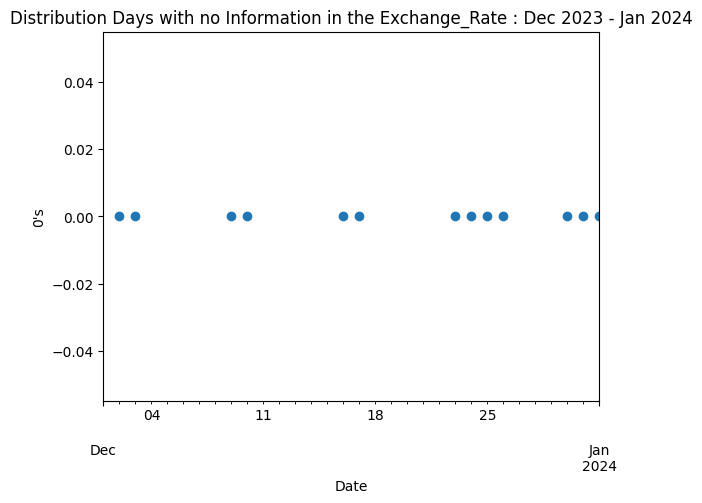

In [24]:
#let's creae a dataframe with the 0's and 1's are replaced with NaN
df_zeros = all_dates_encoded['Exchange_Rate'].replace(1, np.nan)

#as there are many values, let us select a small interval visualize
df_zeros.loc['2023-12-01': '2024-01-01'].plot(style='o')
plt.title("Distribution Days with no Information in the Exchange_Rate : Dec 2023 - Jan 2024")
plt.xlabel("Date")
plt.ylabel("0's")
plt.show()

Observe:

- The blue dots represent days in December 2023 where no values were recorded and it looks that all these days are holidays or weekends
- the 2nd and 3rd of December 2023 fell on a weekend (and no info is marked)
- Hence, the frequency of missing days is most likely connected to data not being recorded on weekends and holidays.

Let's also look at a different month, to get an idea of which days have no information recorded

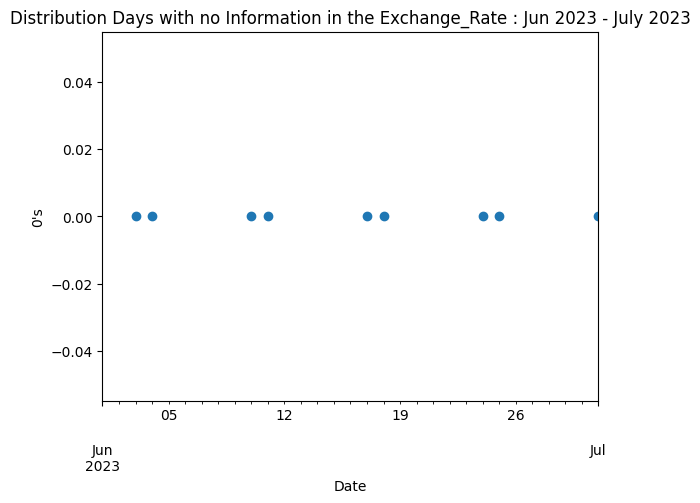

In [25]:
#let's creae a dataframe with the 0's and 1's are replaced with NaN
df_zeros = all_dates_encoded['Exchange_Rate'].replace(1, np.nan)

#as there are many values, let us select a small interval visualize
df_zeros.loc['2023-06-01': '2023-07-01'].plot(style='o')
plt.title("Distribution Days with no Information in the Exchange_Rate : Jun 2023 - July 2023")
plt.xlabel("Date")
plt.ylabel("0's")
plt.show()

Observe :

- Clearly, there is no data on weekends

In [26]:
##let's compare the frequency of weekend time with the value we found
weekend_frequency = 2/7 * 100 ## 2 days out of 7 are weekend days (on average)
print(f"Frequency of weekend days: {weekend_frequency:.2f}%")
print(f"Frequency of days with no information: {noinfo_frequency:.2%}")

Frequency of weekend days: 28.57%
Frequency of days with no information: 29.87%


Judging by this similarity of scores and by the patterns above, it is clear that no data has been recorded on weekends and public holidays. Hence:

- We have exchange rate GBP to EUR data for all days save weekends and public holidays between 1999-01-04 and 2024-01-09
- The data is very clean and there is no apparent reason to doubt it

Now, I will look at the data for gross domestic product, to ensure it is clean

In [27]:
gross_domestic_product.isnull().sum()   

Date           0
GDP            0
 Per Capita    0
GDP_Growth     1
dtype: int64

The GDP growth contains one null. This is actually the first value in the dataframe, as it not possible to have GDP growth information for the first year recorded in the dataframe, as information on the previous year is missing. This should not be a problem, as the data needed is from 1999 onwards.

In [28]:
##change the date column to datetime
gross_domestic_product['Date'] = pd.to_datetime(gross_domestic_product['Date'])

##sort by first entry day and sets the index to be the date column
gross_domestic_product_sorted = gross_domestic_product.sort_values(by='Date', ascending=True).set_index('Date')

##view the first 5 rows of the dataframe
gross_domestic_product_sorted.head()

,GDP,Per Capita,GDP_Growth
Date,,,
1960-12-31,73.233970838233,1397.5949,NaN
1961-12-31,77.741969043148,1472.3858,2.6771
1962-12-31,81.247567647219,1525.7759,1.1029
1963-12-31,86.561965531025,1613.457,4.8744
1964-12-31,94.407562406909,1748.2882,5.5337


Now, all that remains is to select the relevant data

In [29]:
gdp_1999 = gross_domestic_product_sorted.loc['1999-01-01':'2023-12-31']
gdp_1999

,GDP,Per Capita,GDP_Growth
Date,,,
1999-12-31,1689.407711357,28788.9693,3.0141
2000-12-31,1666.0487670798,28289.6527,4.0927
2001-12-31,1648.765214387,27888.6051,2.1574
2002-12-31,1785.7813725539,30078.6081,1.7708
2003-12-31,2056.7045867366,34480.9411,3.1231
2004-12-31,2423.0473470285,40392.2649,2.345
2005-12-31,2544.8131661005,42131.8271,2.6683
2006-12-31,2709.978165671,44537.7123,2.1604
2007-12-31,3092.9964683872,50438.2296,2.5635


The data above is collected at the end of each year, so the month and day information are redundant

In [30]:
##let's extract the year from the date
gdp_1999.loc[:, 'Year'] = gdp_1999.index.year

##let now make the year the index
gdp_1999 = gdp_1999.set_index('Year')

##now we can look at the data
gdp_1999.head()

/var/folders/cm/73d57svx0rq532gb7nffk2m00000gn/T/ipykernel_6499/1721575085.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdp_1999.loc[:, 'Year'] = gdp_1999.index.year


,GDP,Per Capita,GDP_Growth
Year,,,
1999,1689.407711357,28788.9693,3.0141
2000,1666.0487670798,28289.6527,4.0927
2001,1648.765214387,27888.6051,2.1574
2002,1785.7813725539,30078.6081,1.7708
2003,2056.7045867366,34480.9411,3.1231


Observe :

- We can't use this data to make predictions, due to not having enough observations
- It could be useful in assesing the pattern of yearly exhange rate (exchange rate growth per year)

<a class="anchor" id='section3'></a>

# 3. Split the Data

There are two steps in determining how good the models are. First, I will internally validate the model on some test data taken from my data, use an evaluation metric (MAPE in this case) to measure its performance and then test it on real world data to externally validate it

In [31]:
##create test set as the last 3 months of the data
test = gbp_sorted.loc['2023-10-01':]

##create train set as the rest of the data
train = gbp_sorted.loc[:'2023-09-30']

In [32]:
len(train), len(test)

(6339, 69)

In [33]:
##create a copy of the train set for further exploration
explore = train.copy()

All the following exploration is done on the copy of the training set. This is to avoid looking at the test set( I'll treat the test set as new data to validate models)

<a class="anchor" id='section4'></a>


# 4. Explore the Data

## Investigate Seasonality

In the first step, I will investigate the data to see if there is any obvious periodicity. This is because, a time series can be _naively forecasted_ if it changes according to a very obvious relationship. For example, sinusoidal data can very easily be considered periodic, with the maxima and minima being exactly the same at a specific time period called the period T. If a periodic pattern holds,  naive forecasting can be employed by exploiting such periodicities, given a time signal x that is periodic with period T :

$$ x(t) = x(t+T)$$

As naive forecasting is the most basic form of forecasting (just copying the previous value for the intended period), any model must offer a greater performance than naive forecasting to de deployed.



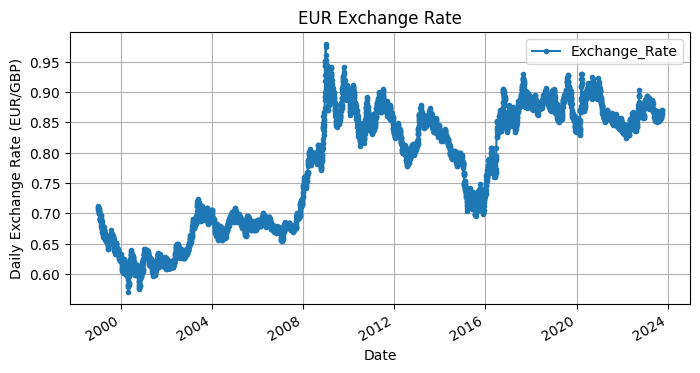

In [34]:
##plot the exchange rate of EUR to GBP
explore.plot(grid=True, marker=".", figsize=(8,4))
plt.title("EUR Exchange Rate")
plt.ylabel("Daily Exchange Rate (EUR/GBP)")
plt.xlabel("Date")
plt.show()

Observe :

- This is a _Univariate time series_ with a single value looked over a series of time
- The EUR is strongest in 2009 (almost equal to the pound)
- The lowest values of the EUR have been recorded in early 2000's and late 2015 
- some of the growth can be explained by major events : the Brexit vote in 2016 led to an increased exchange rate for the euro- devaluing of the pound


In the following, I will investigate if there is (i) weekly or monthly seasonality or (ii) yearly seasonality. This is because sometimes there is a strong weekly, monthly or yearly pattern that allows good predictions. Clearly, for weekly seasonality, it makes sense to investigate a more recent slice of the data, for example 2022-2024. This is for two reasons : 

- (a) the data is more likely to behave similarly over shorter time spans
- (b) to predict the exchange rate in the following weeks, it makes sense to analyze recent weeks as they are part of the same time period.

## Investigate Weekly Seasonality

To make accurate predictions, let us focus on a slice of the data that represents a relatively recent (and stable!) segment. It is clear that the 2022-2024 does not present very strong oscillations as the value of the data is contained within the range 0.85 - 0.9. I'll first look at thi data.

In [35]:
##select slice of data from 2022 onwards
df_2022onwards = explore.loc['2022-01-01':]

In [36]:
df_2022onwards

,Exchange_Rate
Date,
2022-01-03,0.84135
2022-01-04,0.83618
2022-01-05,0.83546
2022-01-06,0.83593
2022-01-07,0.83430
...,...
2023-09-25,0.86965
2023-09-26,0.87020
2023-09-27,0.86810


In [37]:
df_2022onwards.describe()

,Exchange_Rate
count,449.000000
mean,0.860440
std,0.016809
min,0.823880
25%,0.846700
50%,0.859900
75%,0.873950
max,0.902680


In [38]:
len(df_2022onwards)

449

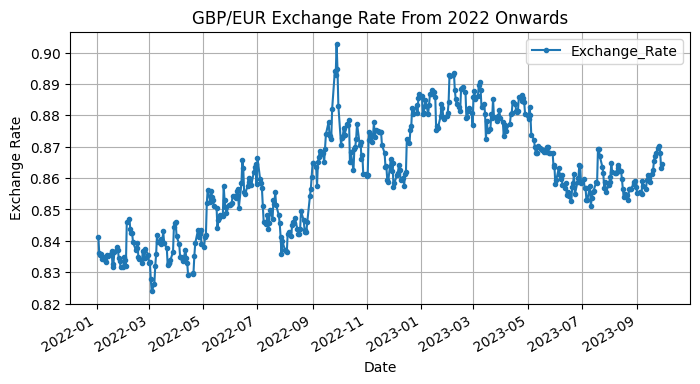

In [39]:
##visualize the data from 2022 onwards
df_2022onwards.plot(grid=True, marker=".", figsize=(8,4))
plt.title("GBP/EUR Exchange Rate From 2022 Onwards")
plt.ylabel("Exchange Rate")
plt.xlabel("Date")
plt.show()


Observe:

- The signal varies between 0.82 and approximately 0.9, with lower exchange values signifiyng a stronger pound
- the pound has been weakest in October 2022 and strongest in January 2022, with 2023 showing overall weakening of the pound

Given the above, I will explore the similarities of the time series with a shifted version of itself over the course of a week. To do this, I will plot the lagged series with 7 days ( a week) and compare (i) the original series, (ii) the lagged time series and (iii) the difference between (i) and (ii) ( the _differenced_ series)

In [40]:
##this is the diffenced time series 
diff_week = df_2022onwards.diff(7)

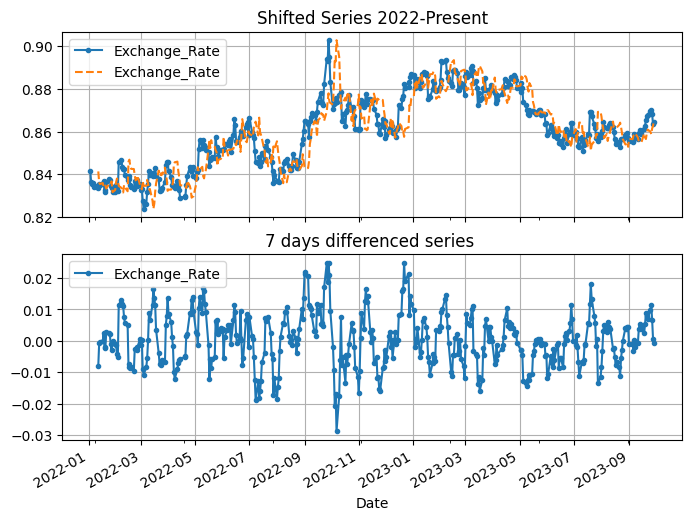

In [41]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 6)) ##Sharex ensures the plot share the same x axis
df_2022onwards.plot(ax=axs[0], grid=True, marker=".", legend="Original",  title="Shifted Series 2022-Present") ##plot the original data
df_2022onwards.shift(7).plot(ax=axs[0], grid=True, linestyle='dashed', legend="Shifted") ##plot the data shifted by 7 days (one week)
diff_week.plot(ax=axs[1], grid=True, marker=".", title="7 days differenced series ") ##plot the differenced data
plt.show()

Observe :

- The top plot presents the values shifted by one week, while the bottom plot shows how much the exchange rate changed over one week
- The lagged series (orange) doesn't seem to follow the orginal series (blue) closely : values change from week to week
- The differenced series does not seem to be stationary yet
- Most differences are in the range -0.02 to 0.02 with the biggest difference at the beggining of October 2022 (around 0.05 fluctuation). 
- The rate of change (the bottom plot) shows that is is mostly oscillating around a constant value of 0, with fluctuations between -0.03 and  0.02 

In [42]:
##calculate the MAE of the differenced series
mae_diff_week = np.abs(diff_week).mean()
print("Mean Absolute Error of the differenced series:", mae_diff_week)

Mean Absolute Error of the differenced series: Exchange_Rate    0.006578
dtype: float64


In [43]:
##calculate the MAPE of the differenced series
mape_diff_week = np.abs(diff_week / df_2022onwards.shift(7)).mean()
print("Mean Absolute Percentage Error of the differenced series:", mape_diff_week)

Mean Absolute Percentage Error of the differenced series: Exchange_Rate    0.007642
dtype: float64


Note: from the differenced series, we obtained a MAPE (Mean Absolute Percentage Error) of around 0.76%, which represents by how much (on average) predictions would be wrong if we would use naive forecasting. To understand the series better, I will look at the auto-correlation function.

In [44]:
##import autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf


<Figure size 1000x800 with 0 Axes>

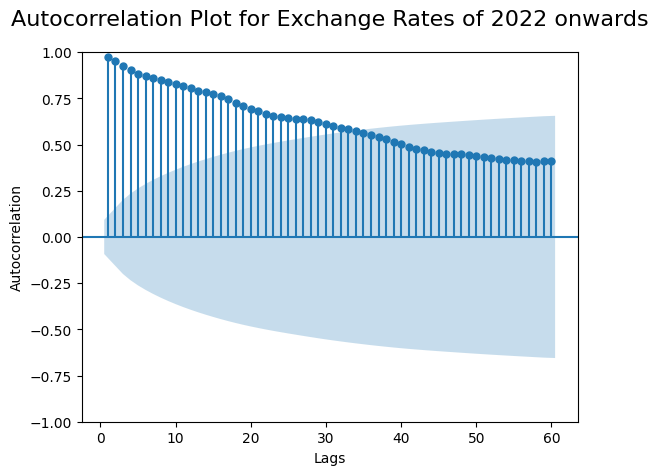

In [45]:
plt.figure(figsize=(10,8))
plot_acf(df_2022onwards, lags=60, zero=False) ##the lag of 30 represents 60 days, for which the autocorrelation is calculated 
plt.title('Autocorrelation Plot for Exchange Rates of 2022 onwards', fontsize=16, y=1.05)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

Observe :

- the auto-correlation function decays with the number of lags, suggesting no seasonality for the daily data
- the first time the auto-correlation function crosses the confidence interval is close to 30 (number of Auto-Regressive terms)


In [46]:
##calculate the autocorrelation of the differenced series
acf_30 = df_2022onwards['Exchange_Rate'].autocorr(lag=30)  

In [47]:
print("Autocorrelation coefficient  value for 30 days lag is:", acf_30) 

Autocorrelation coefficient  value for 30 days lag is: 0.6655277525136581


We could also look at the partial auto-correlation function to understand what is the optimal number of moving average terms.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 1000x800 with 0 Axes>

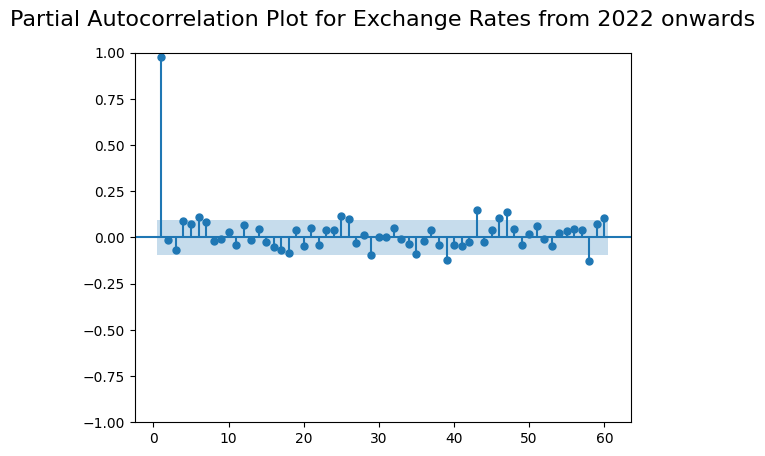

In [48]:
##the partial autocorrelation plot
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(10,8))
plot_pacf(df_2022onwards, lags=60,  zero=False) ##plot the partial autocorrelation
plt.title('Partial Autocorrelation Plot for Exchange Rates from 2022 onwards', fontsize=16, y=1.05)
plt.show()

Observe :

- the sharp decrease of the auto-correlation function clearly shows that the optimal number of moving average terms if 1

I'll also look at the number of times I should difference the series to get a stationary signal.

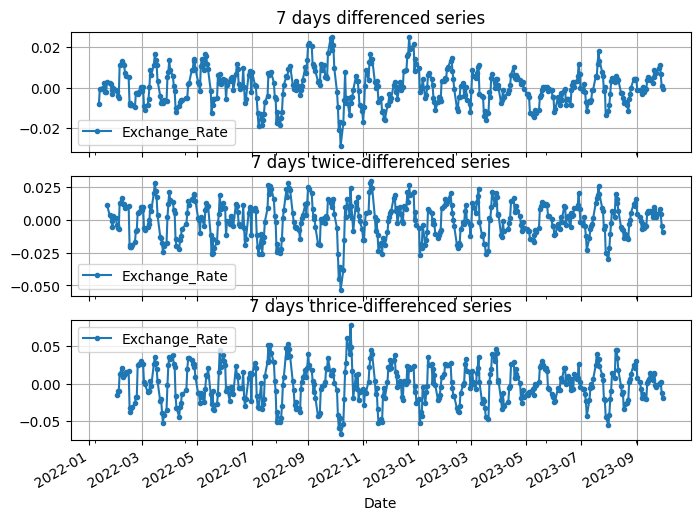

In [49]:
##difference the series by 7 days (again)
diff_week_twice = df_2022onwards.diff(7).diff(7)
##difference the series 3 times 
diff_week_thrice = df_2022onwards.diff(7).diff(7).diff(7)
##plot the differenced series   
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 6))
diff_week.plot(ax=axs[0], grid=True, marker=".", title="7 days differenced series")
diff_week_twice.plot(ax=axs[1], grid=True, marker=".", title="7 days twice-differenced series")
diff_week_thrice.plot(ax=axs[2], grid=True, marker=".", title="7 days thrice-differenced series")
plt.show()


In [50]:
##drop the NaN from the differenced series
diff_week_twice = diff_week_twice.dropna() ##drop the NaN values
diff_week_thrice = diff_week_thrice.dropna() ##drop the NaN values
diff_week = diff_week.dropna() ##drop the NaN values

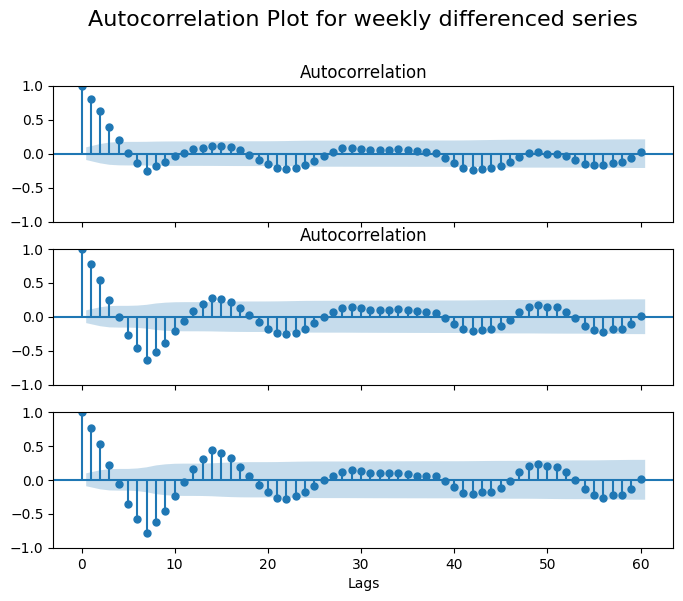

In [51]:
##plot the autocorrelation of the differenced series
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 6)) ##Sharex ensures the plot share the same x axis
plot_acf(diff_week, lags=60, label=False, ax = axs[0]) ##plot the autocorrelation of the differenced series
plot_acf(diff_week_twice, lags=60, ax = axs[1]) ##plot the autocorrelation of the differenced series
plot_acf(diff_week_thrice, lags=60, ax = axs[2]) ##plot the autocorrelation of the differenced series
plt.title('Autocorrelation Plot for weekly differenced series', fontsize=16, y=3.78 )
plt.xlabel('Lags')
plt.show()


Observe :

- applying differencing once makes the model stationary
- applying more rounds of differencing does not seem to help

## Investigate Yearly Seasonality 

To investigate yearly seasonality, I will look at data until 2019, to avoid drawing conclusions from very recent data. The purpose of this analysis is to reveal if there are any _long term_ trends that should be considered. To do this, I will plot the rolling average of the series.

In [52]:
##create a resampled dataframe with the mean exchange rate for monthly periods
period = slice('2001', '2019')
df_monthly = gbp_sorted.resample('M').mean()

In [53]:
##calculate the rolling average for 12 months
rolling_avg = df_monthly['2000': '2019'].rolling(12).mean()

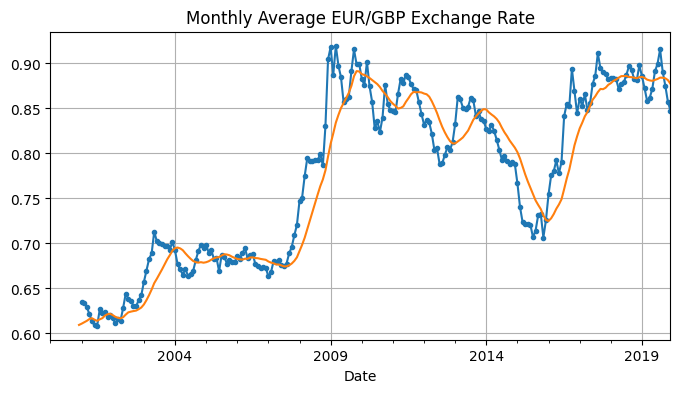

In [54]:
##plot the rolling average and the mean for each month
fig, ax = plt.subplots(figsize=(8,4))
df_monthly[period].plot(ax=ax, grid=True, marker=".", legend=False, title="Monthly Average EUR/GBP Exchange Rate")
rolling_avg.plot(ax=ax, grid=True, legend=False)
plt.show()


Observe:

- I plotted a rolling average of 12 months (one year) against data representing the mean of the exchange rates
- It is quite clear that there is some yearly trends : 2001-2004, 2008-2010 and 2016-2018 show periods of increased exchange rates(on average) : roughly every 7-8 years the average yearly exchange rate has gone up, tipically for 2-3 years before levelling and going down

Before proceeding to modelling the problem, I will plot the 12-month differenced series to see how steady it is


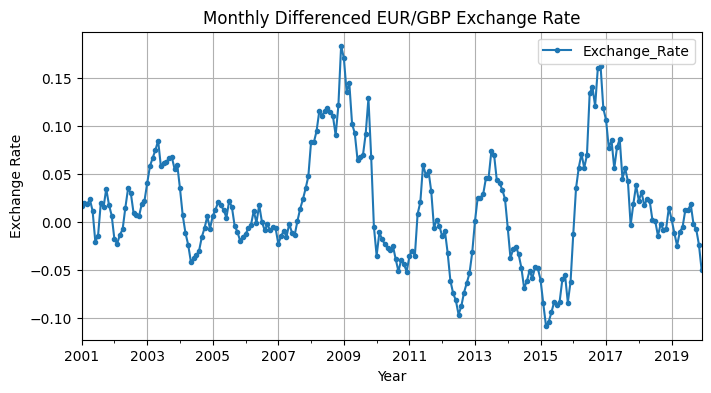

In [55]:
##plots the 12-month differenced series
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8,4))
plt.title("Monthly Differenced EUR/GBP Exchange Rate")
plt.ylabel("Exchange Rate")
plt.xlabel("Year")
plt.show()

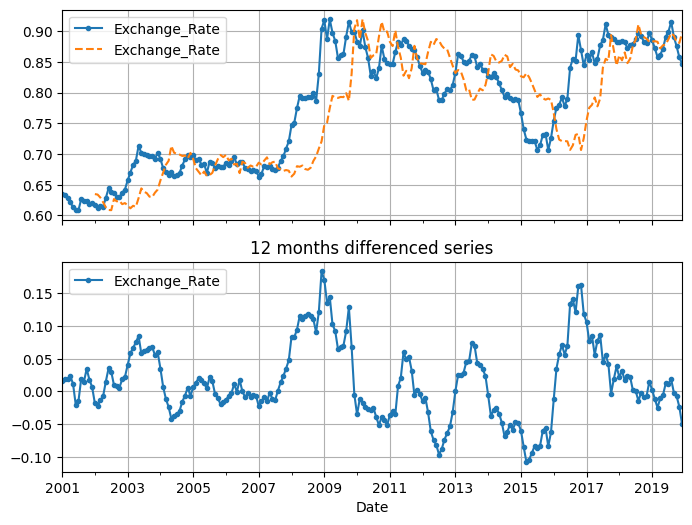

In [56]:
##plot the original and shifted series over 12 months for the monthly sampled data
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
df_monthly[period].plot(ax=axs[0], grid=True, marker=".", legend="Original")
df_monthly[period].shift(12).plot(ax=axs[0], grid=True, linestyle='dashed', legend="Shifted")
df_monthly.diff(12)[period].plot(ax=axs[1], grid=True, marker=".", title="12 months differenced series")
plt.show()


Observe :

- There doesn't seem to be any yearly seasonality either (for the 2001-2019 period)
- The differenced series confirms that the year-to-year changes can be up to 0.15 


## Compare Yearly Exchange Rate with Gross Domestic Product

It could be a good idea to see how the gross domestic product influences the exchange rate. This means plotting the yearly growth in EUR/GBP exchange rate and comparing it with GDP. The first step is to calculate the differences between the exchange rates at the beggining and end of each year (a measure of change) and divide them by the initial value. This would allow for a new dataframe that contains annual changes in the exchange rate of the EUR/GBP and compare these changes with the Gross Domestic Product of the UK.

In [57]:
##create a new column with the difference between the exchange rate of the current day and the previous day

yearly_exchange = pd.DataFrame(index=pd.RangeIndex(1999, 2023), columns = ['Exchange_Rate_Growth(%)'] ) 

for year_current in range(1999, 2023):

    ##select the year
    year_data_current = explore[explore.index.year == year_current]
    

    ##calculate the difference between the exchange rate of the firsr and last day of the year
    delta_exchange_rate = (year_data_current['Exchange_Rate'].iloc[-1] - year_data_current['Exchange_Rate'].iloc[0] )/ year_data_current['Exchange_Rate'].iloc[0] * 100

    ##store the difference in the corresponding year
    yearly_exchange.loc[year_current, 'Exchange_Rate_Growth(%)'] = delta_exchange_rate


In [58]:
yearly_exchange

,Exchange_Rate_Growth(%)
1999,-12.572071
2000,-0.080051
2001,-3.642122
2002,3.880549
2003,8.09816
2004,-0.056701
2005,-3.10357
2006,-2.184996
2007,8.886414
2008,28.49049


Note :

- The exchange rate growth shows how much the pound has changed _in a year_ while _ignoring the fluctuations within a year_
- A negative exchange rate growth means the exchange rate has diminished
- Each year shows the exchange rate growth within that year, as it is calculated from the values at the beggining of the year and end of the year

In the following, let us merge the exchange rate growth and the GDP change from the previous year, to understand how a change in gross domestic product (from the previous year) influences the change in the exchange rate in the current year.

In [59]:
grossdp_exchange = pd.concat([yearly_exchange, gdp_1999], axis=1)
grossdp_exchange.head()


,Exchange_Rate_Growth(%),GDP,Per Capita,GDP_Growth
1999,-12.572071,1689.407711357,28788.9693,3.0141
2000,-0.080051,1666.0487670798,28289.6527,4.0927
2001,-3.642122,1648.765214387,27888.6051,2.1574
2002,3.880549,1785.7813725539,30078.6081,1.7708
2003,8.09816,2056.7045867366,34480.9411,3.1231


In [60]:
grossdp_exchange.columns

Index(['Exchange_Rate_Growth(%)', 'GDP', ' Per Capita', 'GDP_Growth'], dtype='object')

In [61]:
grossdp_exchange.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 1999 to 2022
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Exchange_Rate_Growth(%)  24 non-null     object
 1   GDP                      24 non-null     object
 2    Per Capita              24 non-null     object
 3   GDP_Growth               24 non-null     object
dtypes: object(4)
memory usage: 900.0+ bytes


In [62]:
#convert the columns to numeric
grossdp_exchange["GDP_Growth"] = pd.to_numeric(grossdp_exchange["GDP_Growth"], errors='coerce')
grossdp_exchange["Exchange_Rate_Growth(%)"] = pd.to_numeric(grossdp_exchange["Exchange_Rate_Growth(%)"], errors='coerce')
grossdp_exchange["GDP"] = pd.to_numeric(grossdp_exchange["GDP"], errors='coerce')
grossdp_exchange[" Per Capita"] = pd.to_numeric(grossdp_exchange[" Per Capita"], errors='coerce')




In [63]:
grossdp_exchange.head()

,Exchange_Rate_Growth(%),GDP,Per Capita,GDP_Growth
1999,-12.572071,1689.407711,28788.9693,3.0141
2000,-0.080051,1666.048767,28289.6527,4.0927
2001,-3.642122,1648.765214,27888.6051,2.1574
2002,3.880549,1785.781373,30078.6081,1.7708
2003,8.098160,2056.704587,34480.9411,3.1231


As a fisrt step, I will plot the two time series, Exchange and GDP growth and see how they behave at a yearly level

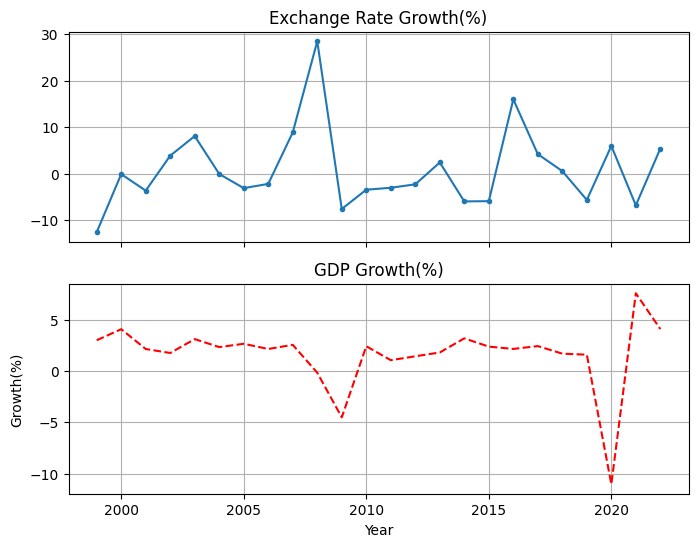

In [64]:
fig ,axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

grossdp_exchange['Exchange_Rate_Growth(%)'].plot(ax=axs[0], grid=True, marker=".", label= 'Exchange Rate', title="Exchange Rate Growth(%)")
grossdp_exchange['GDP_Growth'].plot(ax=axs[1], grid=True, linestyle='dashed', color='red', label= 'GDP Growth', title="GDP Growth(%)")

plt.xlabel("Year")
plt.ylabel("Growth(%)")
plt.show()



Observe :
 
- For specific years, such as 2020, decrease in GDP leads to devaluation of the pound (the above graph shows the EUR/Pound exchange rate)
- Hence, there seems to be a connection between the exchange rate and gross domestic product: when the gross domestic product decreases, the pound also weakens

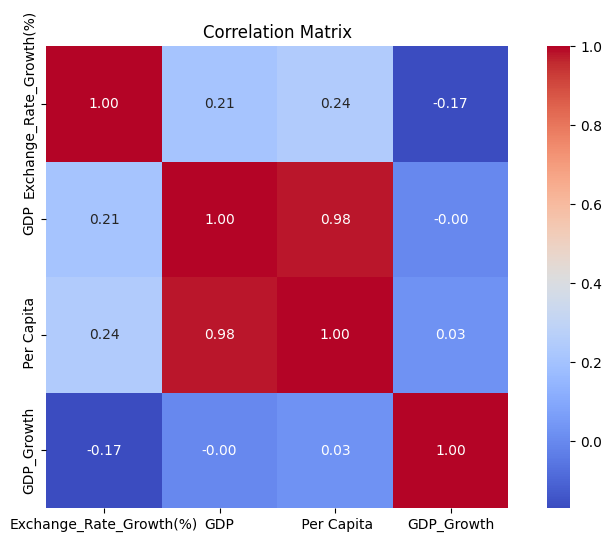

In [65]:
##plot correlation matrix
corr_gdp_exchange = grossdp_exchange.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr_gdp_exchange, annot=True, cmap='coolwarm', cbar=True, square=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


Observe :

- The negative correlation between GDP exchange and the exchange rate is -17%
- Since the exchange rate is EUR to pound, a higher value of EUR to GDP means an decrease in the pound value 
- Hence, GDP Growth actually is negatively correlated to the EUR valuation with respect to the Pound, and therefore positively correlated to GDP
- There is 24% correlation between Per Capita GDP and the Exchange Rate : this mean that higher GDP per capita in that year ia somewhat correlated with higher exchange rates

<a class="anchor" id='section5'></a>


# 5. ARMA model - Baseline

## ARIMA

First, I will explore several ARMA models to see how succesful are they in predicting the time series. ARMA uses an auto-regressive model that computes a weighted sum of past values to which it adds a sum of forecast errors (the moving average component). The model applies subsequent differencing to the data, making it stationary and then extracting predictions. I will use ARIMA as this generally considers weekly seasonality

In [66]:
##import ARIMA model
from statsmodels.tsa.arima.model import ARIMA

As seen before, the exchange rate has been quite unstable over the years, since there are larger events that affect the exchange rate (world economic crises, brexit etc). Hence, I will consider training the model for only the last two years (2022, 2023) and then internally validating it on the test set. Finally, predictions can be made on new data (as provided by the ECB)

In [67]:
train_subsample = train.loc["2022":] ##select the data (from the training set) from 2022 onwards
len(train_subsample)

449

In [68]:
len(test)

69

In [69]:
##build the model
model = ARIMA(train_subsample,
               order=(34,1,1) ##30 AR terms, 1 rounds of differencing, 1 MA term
              ) 
##fit the model
model = model.fit()


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Observe : 

- the "ValueWarning" comes from not specifying the daily frequency "D", as the data will have probably introduced NaN's corresponding to the weekend's and public holidays

In [70]:
tom_pred = model.forecast() 


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [71]:
tom_pred    

449    0.864542
dtype: float64

Observe :

- the value above is the prediction for "tomorrow", where "tomorrow" is simply the first value in the test set
- the index 449 is arbitrary, because ARIMA predicts the _next entry in the series_ and assigns an index representing the order in the sequence 


In [72]:
##check the first entry in the test set
test.head(1)

,Exchange_Rate
Date,
2023-10-02,0.86628


In [73]:
tom_real = test.loc['2023-10-02'] ##select the first entry in the test set
tom_real.iloc[0]   

0.86628

In [74]:
Mape_tom = np.abs((tom_real.iloc[0] - tom_pred.iloc[0]) / tom_real.iloc[0]) * 100 ##calculate the MAPE
Mape_tom

0.20059214713883602

Observe :

<ul>

- the mean percentage absolute error for one day is 0.2%, which represents how different the prediction is
- for the 2nd of October 2023 (the data representing "tomorrow", the first entry in the test set) this is better than naive forecasting that has a MAPE=0.76%

</ul>

Next steps :

<ul>

- predict the values for the next 69 days (the size of the test set)
- ensure that values in the predicted dataframe have the appropiate date (weekend data are missing) by matching the index with the test set
- calculate MAPE with the actual values as targets

</ul>



In [75]:
test_predict = model.forecast(steps=69) ##predict the next 69 days (entries in the test set)
test_predict = pd.DataFrame(test_predict) ##convert the prediction to a dataframe
test_predict.index = test.index ##set the index of the prediction to be the same as the test set
test_predict.head() ##view the first 5 entries of the prediction

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,predicted_mean
Date,
2023-10-02,0.864542
2023-10-03,0.864553
2023-10-04,0.865471
2023-10-05,0.866233
2023-10-06,0.866698


I'll create a new dataframe by merging the predicted values with the actual value

In [76]:
##change the name of the column to 'Exchange_Rate_predicted'
test_predict.columns = ['Exchange_Rate_predicted']
test_predict.head()

,Exchange_Rate_predicted
Date,
2023-10-02,0.864542
2023-10-03,0.864553
2023-10-04,0.865471
2023-10-05,0.866233
2023-10-06,0.866698


In [77]:
test_mape_pred = test_predict.merge(test, how='inner', on='Date') ##merge the prediction with the test set
test_mape_pred.head()

,Exchange_Rate_predicted,Exchange_Rate
Date,,
2023-10-02,0.864542,0.86628
2023-10-03,0.864553,0.86775
2023-10-04,0.865471,0.86588
2023-10-05,0.866233,0.86605
2023-10-06,0.866698,0.86510


In [78]:
test_mape_pred["Prediction_Error"] = np.abs(test_mape_pred['Exchange_Rate'] - test_mape_pred['Exchange_Rate_predicted']) ##calculate the prediction error
test_mape_pred.head()

,Exchange_Rate_predicted,Exchange_Rate,Prediction_Error
Date,,,
2023-10-02,0.864542,0.86628,0.001738
2023-10-03,0.864553,0.86775,0.003197
2023-10-04,0.865471,0.86588,0.000409
2023-10-05,0.866233,0.86605,0.000183
2023-10-06,0.866698,0.86510,0.001598


In [79]:
mape_arima = np.abs((test_mape_pred['Exchange_Rate'] - test_mape_pred['Exchange_Rate_predicted']) / test_mape_pred['Exchange_Rate']).mean() * 100 ##calculate the MAPE
mape_arima 

0.5528265551417674

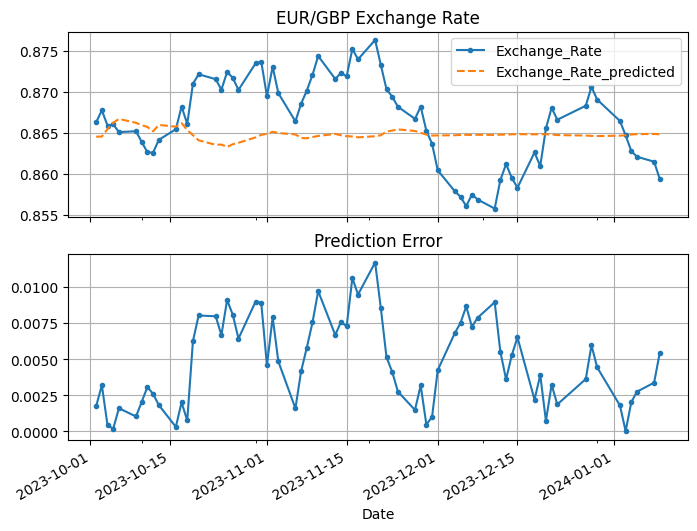

In [80]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
test_mape_pred['Exchange_Rate'].plot(ax=axs[0], grid=True, marker=".", legend="Original", title="EUR/GBP Exchange Rate")
test_mape_pred['Exchange_Rate_predicted'].plot(ax=axs[0], grid=True, linestyle='dashed', legend="Predicted")
test_mape_pred['Prediction_Error'].plot(ax=axs[1], grid=True, marker=".", title="Prediction Error")
plt.show()


Observe :

- the MAPE is about 0.55%
- the predictions ignore any oscillations and are centered around the mean of the signal 
- predictions get worse as time goes on (model decay)
- the model does reasonably good predictions in the first couple of weeks compared to the next periods 

Let's try to see the model efficiency only on the first two weeks of the test set (2023-10-01 : 2023-10-15)

In [81]:
test_mape_beginOct2023 = test_mape_pred.loc['2023-10-01': '2023-10-15'] ##select the data from 2023-10-01 to 2023-10-15
test_mape_beginOct2023.head()

,Exchange_Rate_predicted,Exchange_Rate,Prediction_Error
Date,,,
2023-10-02,0.864542,0.86628,0.001738
2023-10-03,0.864553,0.86775,0.003197
2023-10-04,0.865471,0.86588,0.000409
2023-10-05,0.866233,0.86605,0.000183
2023-10-06,0.866698,0.86510,0.001598


In [82]:
mape_2week_Oct23 = np.abs((test_mape_beginOct2023['Exchange_Rate'] - test_mape_beginOct2023['Exchange_Rate_predicted']) / test_mape_beginOct2023['Exchange_Rate']).mean() * 100 ##calculate the MAPE
mape_2week_Oct23


0.2043923448121591

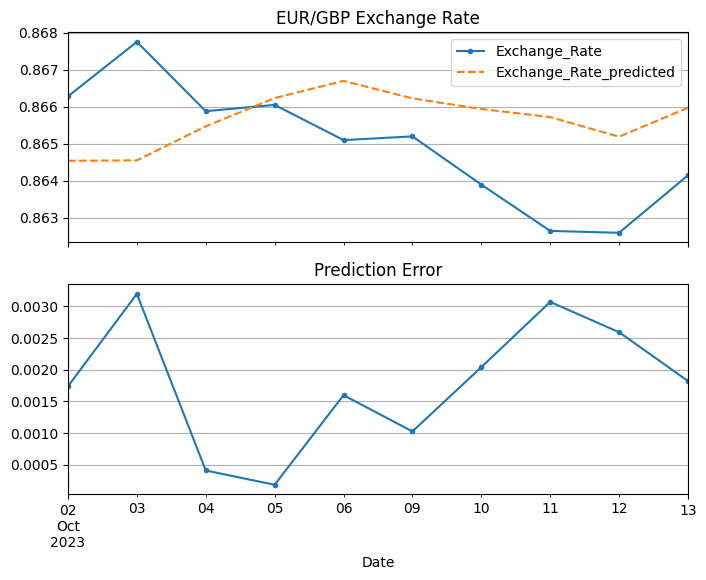

In [83]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
test_mape_beginOct2023['Exchange_Rate'].plot(ax=axs[0], grid=True, marker=".", legend="Original", title="EUR/GBP Exchange Rate")
test_mape_beginOct2023['Exchange_Rate_predicted'].plot(ax=axs[0], grid=True, linestyle='dashed', legend="Predicted")
test_mape_beginOct2023['Prediction_Error'].plot(ax=axs[1], grid=True, marker=".", title="Prediction Error")
plt.show()


Observe :

- the MAPE improves at 0.2%  for the first two weeks of the test data
- prediction errors still become worse as time goes
- ARIMA is mostly a linear model, and in this case I haven't considered any seasonality components 



Conclusions on ARIMA :

<ul>

- the model seems to predict well the average of the signal, but, as expected, it ignores the fluctuations (ARMA models work well with stationary signals)
- on the first two weeks it performs with a MAPE of 0.2%
- On the entire test set (3 months) it's mape is worse than on the first 2 weeks : 0.55% indicating that the model decays (which is normal)

</ul>

Next steps :

<ul>

- Pre-process data for RNN architectures
- Define an evaluation function for the data
- Experiment with different RNN model and see if the baseline can be beaten

</ul>


<a class='anchor' id="section6"></a>

# 6. Prepare Data for RNN's

The purpose of this section is two-fold :

1. Define a fit and evaluate function to fit and test any subsequent RNN's
2. Pre-process data for training/validating/testing any RNN models

In [84]:
##import tensorflow and keras
import tensorflow as tf
from tensorflow import keras


## Evaluation Function

In [85]:
%%time
##define deep learning evaluatuion function with SGD optimizer

def fit_and_evaluate_function_SGD(model, train_set, valid_set, learning_rate, epochs):

    ##define early stopping callback to prevent overfitting
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="mae", patience=20, restore_best_weights=True)
    
    ##this is the optimizer (SGD, ADAM, etc.)
    opt = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate)

    ##compile model with MAE metric
    model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=opt, metrics=["mae"])

    ##fit the model
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])

    ##evaluate the validation error 
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae 

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 2.86 µs


In [86]:
%%time
##define deep learning evaluation function with ADAM optimizer

def fit_and_evaluate_function_Adam(model, train_set, valid_set, learning_rate, epochs):

    ##define early stopping callback to prevent overfitting
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="mae", patience=20, restore_best_weights=True)
    
    ##this is the optimizer (SGD, ADAM, etc.)
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)

    ##compile model with MAE metric
    model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=opt, metrics=["mae"])

    ##fit the model
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])

    ##evaluate the validation error 
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae 

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.86 µs


In [87]:
training_rnn = gbp_sorted.loc['2022-01-01':'2023-11-01'] ##select the training set (until November 2023)
valid_rnn = gbp_sorted.loc['2023-10-01': '2023-11-30'] ##select the validation set (the entire month of November 2023)
test_rnn = gbp_sorted.loc['2023-12-01': '2023-12-31'] ## select the test set (the entire moth of December 2023)

Note: 

- The data is already between 0 and 1, so there is no need for scalling it

In [88]:
##define the sequence length
sequence_length = 19 ## 19 days to look back  (about 2 weeks)


In [89]:
tf.random.set_seed(42) ##set the seed for reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    training_rnn.to_numpy(), ##convert the training set to numpy 
    targets=training_rnn[sequence_length:], ##set the targets to be the sequence length
    sequence_length=sequence_length, ##initialize the sequence length
    batch_size=1, 
    shuffle=True, 
    seed=42) ##set the seed for reproducibility

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    valid_rnn.to_numpy(),
    targets=valid_rnn[sequence_length:],
    sequence_length=sequence_length,
    batch_size=1,
    seed=42)


<a class='anchor' id=section7> </a>

# 7. RNN-based models

I'll start by taking a simple RNN architecture. Since I am using a GPU, results might not be entirely consistent even when using the same architecture. Hence, for each model, I will run it 10 times and record the loss to obtain an idea of its performance.

In [90]:
%%time
tf.random.set_seed(42)  ##sets the seed for the random number generator
simple_rnn = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(40, input_shape=[None, 1]), ##40 neurons in the hidden layer 
    tf.keras.layers.Dense(1)  # added a relu activation function
])

CPU times: user 42.2 ms, sys: 2.2 ms, total: 44.4 ms
Wall time: 43.8 ms


In [91]:
%%time 
##fit and evaluate the model 10 times
mae_scores = [] ##initialize an empty list to store the MAE scores
for i in range(10):
    mae = fit_and_evaluate_function_SGD(simple_rnn, train_ds, valid_ds, learning_rate=0.01, epochs=400) ##fit and evaluate the model
    mae_scores.append(mae) ##append the MAE score to the list
    print(f"MAE score {i+1}: {mae:.4f}") ##print the MAE score


Epoch 1/400


2024-02-07 23:41:07.887510: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [453]
	 [[{{node Placeholder/_28}}]]
2024-02-07 23:41:07.887791: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


453/453 [==============================] - 1s 1ms/step - loss: 0.0670 - mae: 0.0670 - val_loss: 0.0290 - val_mae: 0.0290
Epoch 2/400
 62/453 [===>..........................] - ETA: 0s - loss: 0.0439 - mae: 0.0439

2024-02-07 23:41:08.736055: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [25,1]
	 [[{{node Placeholder/_20}}]]
2024-02-07 23:41:08.736305: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [25,1]
	 [[{{node Placeholder/_20}}]]


453/453 [==============================] - 0s 873us/step - loss: 0.0406 - mae: 0.0406 - val_loss: 0.0545 - val_mae: 0.0545
Epoch 3/400
453/453 [==============================] - 0s 865us/step - loss: 0.0323 - mae: 0.0323 - val_loss: 0.0604 - val_mae: 0.0604
Epoch 4/400
453/453 [==============================] - 0s 869us/step - loss: 0.0284 - mae: 0.0284 - val_loss: 0.0473 - val_mae: 0.0473
Epoch 5/400
453/453 [==============================] - 0s 860us/step - loss: 0.0253 - mae: 0.0253 - val_loss: 0.0347 - val_mae: 0.0347
Epoch 6/400
453/453 [==============================] - 0s 865us/step - loss: 0.0228 - mae: 0.0228 - val_loss: 0.0193 - val_mae: 0.0193
Epoch 7/400
453/453 [==============================] - 0s 862us/step - loss: 0.0217 - mae: 0.0217 - val_loss: 0.0053 - val_mae: 0.0053
Epoch 8/400
453/453 [==============================] - 0s 936us/step - loss: 0.0203 - mae: 0.0203 - val_loss: 0.0289 - val_mae: 0.0289
Epoch 9/400
453/453 [==============================] - 0s 954us/ste

In [92]:
print(f"Mean MAE: {np.mean(mae_scores):.4f}") ##print the mean MAE score
print(f"Standard deviation of MAE: {np.std(mae_scores):.4f}") ##print the standard deviation of the MAE scores

Mean MAE: 0.0088
Standard deviation of MAE: 0.0071


Observe :

- the mean MAE of evaluating this simple architecture over the evaluation set is 0.007
- the standard deviation is about half the mean value, which shows the values are quite spread out


Next, I'll make the model more complex, by adding an extra layer and more neurons.

In [93]:
%%time
tf.random.set_seed(42)  
deeper_rnn = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(40, return_sequences=True, input_shape=[None, 1], dropout=0.2, activation='relu'), ##40 neurons in the hidden layer with a dropout of 0.2
    tf.keras.layers.SimpleRNN(50, dropout=0.4, activation='relu'), ##the last layer does not need to return sequences
    tf.keras.layers.Dense(1) ##fully connected layer with one output neuron
])

CPU times: user 82.9 ms, sys: 7.76 ms, total: 90.7 ms
Wall time: 91 ms


In [94]:
%%time
##fit and evaluate the model
mae_scores = [] ##initialize an empty list to store the MAE scores
for i in range(10):
    mae = fit_and_evaluate_function_Adam(deeper_rnn, train_ds, valid_ds, learning_rate=0.01, epochs=400) ##fit and evaluate the model
    mae_scores.append(mae) ##append the MAE score to the list
    print(f"MAE score {i+1}: {mae:.4f}") ##print the MAE score


Epoch 1/400
453/453 [==============================] - 2s 3ms/step - loss: 0.0816 - mae: 0.0816 - val_loss: 0.0252 - val_mae: 0.0252
Epoch 2/400
453/453 [==============================] - 1s 2ms/step - loss: 0.0247 - mae: 0.0247 - val_loss: 0.0121 - val_mae: 0.0121
Epoch 3/400
453/453 [==============================] - 1s 2ms/step - loss: 0.0212 - mae: 0.0212 - val_loss: 0.0302 - val_mae: 0.0302
Epoch 4/400
453/453 [==============================] - 1s 2ms/step - loss: 0.0177 - mae: 0.0177 - val_loss: 0.0058 - val_mae: 0.0058
Epoch 5/400
453/453 [==============================] - 1s 2ms/step - loss: 0.0175 - mae: 0.0175 - val_loss: 0.0296 - val_mae: 0.0296
Epoch 6/400
453/453 [==============================] - 1s 2ms/step - loss: 0.0174 - mae: 0.0174 - val_loss: 0.0028 - val_mae: 0.0028
Epoch 7/400
453/453 [==============================] - 1s 2ms/step - loss: 0.0177 - mae: 0.0177 - val_loss: 0.0286 - val_mae: 0.0286
Epoch 8/400
453/453 [==============================] - 1s 2ms/step - 

KeyboardInterrupt: 

In [ ]:
print(f"Mean MAE: {np.mean(mae_scores):.4f}") ##print the mean MAE score
print(f"Standard deviation of MAE: {np.std(mae_scores):.4f}") ##print the standard deviation of the MAE scores

Mean MAE: 0.0085
Standard deviation of MAE: 0.0050


Observe:

- Adding an extra layer gave similar results in terms of mean and std



I'll try to add a LTSM cell to the model and evaluate predictions

In [ ]:
ltsm_model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(40, return_sequences=True, input_shape=[None, 1], dropout=0.2, activation='relu'),
    tf.keras.layers.SimpleRNN(50, return_sequences=True, dropout=0.4, activation='relu'),
    tf.keras.layers.LSTM(50, return_sequences=True, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

In [ ]:
%%time
##fit and evalaute with LTMS
mae_scores = [] ##initialize an empty list to store the MAE scores
for i in range(10):
    mae = fit_and_evaluate_function_Adam(ltsm_model, train_ds, valid_ds, learning_rate=0.01, epochs=400) ##fit and evaluate the model
    mae_scores.append(mae) ##append the MAE score to the list
    print(f"MAE score {i+1}: {mae:.4f}") ##print the MAE score


Epoch 1/400
453/453 [==============================] - 3s 5ms/step - loss: 0.0216 - mae: 0.0216 - val_loss: 0.0105 - val_mae: 0.0105
Epoch 2/400
453/453 [==============================] - 2s 4ms/step - loss: 0.0162 - mae: 0.0162 - val_loss: 0.0066 - val_mae: 0.0066
Epoch 3/400
453/453 [==============================] - 2s 4ms/step - loss: 0.0157 - mae: 0.0157 - val_loss: 0.0031 - val_mae: 0.0031
Epoch 4/400
453/453 [==============================] - 2s 4ms/step - loss: 0.0150 - mae: 0.0150 - val_loss: 0.0162 - val_mae: 0.0162
Epoch 5/400
453/453 [==============================] - 2s 4ms/step - loss: 0.0148 - mae: 0.0148 - val_loss: 0.0066 - val_mae: 0.0066
Epoch 6/400
453/453 [==============================] - 2s 4ms/step - loss: 0.0146 - mae: 0.0146 - val_loss: 0.0026 - val_mae: 0.0026
Epoch 7/400
453/453 [==============================] - 2s 4ms/step - loss: 0.0146 - mae: 0.0146 - val_loss: 0.0113 - val_mae: 0.0113
Epoch 8/400
453/453 [==============================] - 2s 4ms/step - 

In [ ]:
print(f"Mean MAE: {np.mean(mae_scores):.4f}") ##print the mean MAE score
print(f"Standard deviation of MAE: {np.std(mae_scores):.4f}") ##print the standard deviation of the MAE scores


Mean MAE: 0.0068
Standard deviation of MAE: 0.0006


Observe: 

- the MAE values are comparable, but the model is more stable (the standard deviatin is less than before)
- we do get slighlty better results with the LTSM cell

I'll try a 1D-Convolution model 

In [ ]:
tf.random.set_seed(42)  
conv_rnn_model = tf.keras.Sequential([
                        tf.keras.layers.SimpleRNN(40, return_sequences=True, input_shape=[None, 1], dropout=0.2, activation='relu'),
                        tf.keras.layers.SimpleRNN(50, return_sequences=True, dropout=0.4, activation='relu'),
                        tf.keras.layers.LSTM(50, return_sequences=True, activation='relu'), 
                        tf.keras.layers.Conv1D(filters=32, kernel_size=7, strides=1,
                              activation="relu", padding="same"),
                        tf.keras.layers.Conv1D(filters=32, kernel_size=7, strides=1,
                           activation="relu", padding="same"),
                        tf.keras.layers.Dense(1, activation='sigmoid')
]) 

In [ ]:
%%time
##fit and evaluate the model with ADAM
mae_scores = [] ##initialize an empty list to store the MAE scores
for i in range(10):
    mae = fit_and_evaluate_function_Adam(conv_rnn_model, train_ds, valid_ds, learning_rate=0.01, epochs=400) ##fit and evaluate the model
    mae_scores.append(mae) ##append the MAE score to the list
    print(f"MAE score {i+1}: {mae:.4f}") ##print the MAE score

Epoch 1/400
453/453 [==============================] - 3s 5ms/step - loss: 0.0238 - mae: 0.0238 - val_loss: 0.0129 - val_mae: 0.0129
Epoch 2/400
453/453 [==============================] - 2s 4ms/step - loss: 0.0155 - mae: 0.0155 - val_loss: 0.0089 - val_mae: 0.0089
Epoch 3/400
453/453 [==============================] - 2s 4ms/step - loss: 0.0153 - mae: 0.0153 - val_loss: 0.0033 - val_mae: 0.0033
Epoch 4/400
453/453 [==============================] - 2s 4ms/step - loss: 0.0151 - mae: 0.0151 - val_loss: 0.0163 - val_mae: 0.0163
Epoch 5/400
453/453 [==============================] - 2s 4ms/step - loss: 0.0151 - mae: 0.0151 - val_loss: 0.0112 - val_mae: 0.0112
Epoch 6/400
453/453 [==============================] - 2s 4ms/step - loss: 0.0155 - mae: 0.0155 - val_loss: 0.0089 - val_mae: 0.0089
Epoch 7/400
453/453 [==============================] - 2s 4ms/step - loss: 0.0152 - mae: 0.0152 - val_loss: 0.0046 - val_mae: 0.0046
Epoch 8/400
453/453 [==============================] - 2s 4ms/step - 

In [ ]:
print(f"Mean MAE: {np.mean(mae_scores):.4f}") ##print the mean MAE score
print(f"Standard deviation of MAE: {np.std(mae_scores):.4f}") ##print the standard deviation of the MAE scores

Mean MAE: 0.0074
Standard deviation of MAE: 0.0012


Notes on adding convolutional layers :

<ul>

- the model becomes quite reliable (standard deviation is quite small) indicating very simillar values of MAE on each run
- but MAE is not significantly affected


</ul>





I'll add a GRU layer to the convolutional layers above. This is the convolutional layer can shorten the sequence that must be processed by the GRU cell - which doesn't have a long memory span.

In [ ]:
tf.random.set_seed(42)  
conv_rnn_model_GRU = tf.keras.Sequential([
                        tf.keras.layers.Conv1D(filters=32, kernel_size=7, strides=3,
                           activation="relu", input_shape=[None, 1]),
                        tf.keras.layers.GRU(32, return_sequences=True),
                        tf.keras.layers.Dense(1, activation='sigmoid')
]) 

In [ ]:
%%time
##fit and evaluate the model with ADAM
mae_scores = [] ##initialize an empty list to store the MAE scores
for i in range(10):
    mae = fit_and_evaluate_function_Adam(conv_rnn_model_GRU, train_ds, valid_ds, learning_rate=0.01, epochs=400) ##fit and evaluate the model
    mae_scores.append(mae) ##append the MAE score to the list
    print(f"MAE score {i+1}: {mae:.4f}") ##print the MAE score


Epoch 1/400
453/453 [==============================] - 2s 2ms/step - loss: 0.0228 - mae: 0.0228 - val_loss: 0.0029 - val_mae: 0.0029
Epoch 2/400
453/453 [==============================] - 0s 1ms/step - loss: 0.0148 - mae: 0.0148 - val_loss: 0.0037 - val_mae: 0.0037
Epoch 3/400
453/453 [==============================] - 0s 1ms/step - loss: 0.0148 - mae: 0.0148 - val_loss: 0.0066 - val_mae: 0.0066
Epoch 4/400
453/453 [==============================] - 0s 1ms/step - loss: 0.0144 - mae: 0.0144 - val_loss: 0.0064 - val_mae: 0.0064
Epoch 5/400
453/453 [==============================] - 0s 1ms/step - loss: 0.0146 - mae: 0.0146 - val_loss: 0.0145 - val_mae: 0.0145
Epoch 6/400
453/453 [==============================] - 0s 1ms/step - loss: 0.0143 - mae: 0.0143 - val_loss: 0.0067 - val_mae: 0.0067
Epoch 7/400
453/453 [==============================] - 0s 1ms/step - loss: 0.0141 - mae: 0.0141 - val_loss: 0.0178 - val_mae: 0.0178
Epoch 8/400
453/453 [==============================] - 0s 1ms/step - 

In [ ]:
print(f"Mean MAE: {np.mean(mae_scores):.4f}") ##print the mean MAE score
print(f"Standard deviation of MAE: {np.std(mae_scores):.4f}") ##print the standard deviation of the MAE scores

Mean MAE: 0.0096
Standard deviation of MAE: 0.0030


Based on the performing multiple experiments for the above architectures, it looks like using  the "conv_rnn_model" could be the best choice, both in terms of MAE and its variance with respect to MAE calculated over multiple iterations of the model. However, the Convolutional-Gru model is far less complex (with only three layers) and produces quite good results. Since there is no clear massive advantage of using the more complex model, I will use the Comvolutional-GRU, which will be fine-tuned to give the best possible performance.

<a class='anchor' id =section8></a>

# 8. Fine Tune Best model

The aim of this section is to find better hyper-parameters for the RNN model, before proceeding to the comparison with the baseline (ARIMA).

In the following, I will experiment with the model's learning rate and number of epochs

In [ ]:
##this is the selected model
tf.random.set_seed(42)
conv_rnn_model_GRU = tf.keras.Sequential([
                        tf.keras.layers.Conv1D(filters=32, kernel_size=7, strides=1, ##32 filters, kernel size of 7, stride of 1
                           activation="relu", input_shape=[None, 1]),
                        tf.keras.layers.GRU(32, return_sequences=True),
                        tf.keras.layers.Dense(1, activation='sigmoid')
]) 

In [ ]:
%%time
##fit and evaluate the model with Adam
mae_scores = [] ##initialize an empty list to store the MAE scores
for i in range(10):
    mae = fit_and_evaluate_function_Adam(conv_rnn_model_GRU, train_ds, valid_ds, learning_rate=0.01, epochs=400) 
    mae_scores.append(mae) ##append the MAE score to the list
    print(f"MAE score {i+1}: {mae:.4f}") ##print the MAE score


Epoch 1/400


453/453 [==============================] - 2s 2ms/step - loss: 0.0225 - mae: 0.0225 - val_loss: 0.0173 - val_mae: 0.0173
Epoch 2/400
453/453 [==============================] - 1s 2ms/step - loss: 0.0155 - mae: 0.0155 - val_loss: 0.0189 - val_mae: 0.0189
Epoch 3/400
453/453 [==============================] - 1s 2ms/step - loss: 0.0148 - mae: 0.0148 - val_loss: 0.0119 - val_mae: 0.0119
Epoch 4/400
453/453 [==============================] - 1s 2ms/step - loss: 0.0154 - mae: 0.0154 - val_loss: 0.0029 - val_mae: 0.0029
Epoch 5/400
453/453 [==============================] - 1s 2ms/step - loss: 0.0144 - mae: 0.0144 - val_loss: 0.0069 - val_mae: 0.0069
Epoch 6/400
453/453 [==============================] - 1s 2ms/step - loss: 0.0138 - mae: 0.0138 - val_loss: 0.0085 - val_mae: 0.0085
Epoch 7/400
453/453 [==============================] - 1s 2ms/step - loss: 0.0150 - mae: 0.0150 - val_loss: 0.0092 - val_mae: 0.0092
Epoch 8/400
453/453 [==============================] - 1s 2ms/step - loss: 0.0146

In [ ]:
print(f"Mean MAE: {np.mean(mae_scores):.4f}") ##print the mean MAE score
print(f"Standard deviation of MAE: {np.std(mae_scores):.4f}") ##print the standard deviation of the MAE scores

Mean MAE: 0.0072
Standard deviation of MAE: 0.0036


In [ ]:
%%time
##fit and evaluate the model with Adam
mae_scores = [] ##initialize an empty list to store the MAE scores
for i in range(10):
    mae = fit_and_evaluate_function_Adam(conv_rnn_model_GRU, train_ds, valid_ds, learning_rate=0.1, epochs=400) ## change learning rate to 0.1
    mae_scores.append(mae) ##append the MAE score to the list
    print(f"MAE score {i+1}: {mae:.4f}") ##print the MAE score


Epoch 1/400
453/453 [==============================] - 2s 2ms/step - loss: 0.0174 - mae: 0.0174 - val_loss: 0.0226 - val_mae: 0.0226
Epoch 2/400
453/453 [==============================] - 1s 2ms/step - loss: 0.0178 - mae: 0.0178 - val_loss: 0.0050 - val_mae: 0.0050
Epoch 3/400
453/453 [==============================] - 1s 2ms/step - loss: 0.0168 - mae: 0.0168 - val_loss: 0.0100 - val_mae: 0.0100
Epoch 4/400
453/453 [==============================] - 1s 2ms/step - loss: 0.0177 - mae: 0.0177 - val_loss: 0.0076 - val_mae: 0.0076
Epoch 5/400
453/453 [==============================] - 1s 2ms/step - loss: 0.0173 - mae: 0.0173 - val_loss: 0.0209 - val_mae: 0.0209
Epoch 6/400
453/453 [==============================] - 1s 2ms/step - loss: 0.0168 - mae: 0.0168 - val_loss: 0.0281 - val_mae: 0.0281
Epoch 7/400
453/453 [==============================] - 1s 2ms/step - loss: 0.0184 - mae: 0.0184 - val_loss: 0.0154 - val_mae: 0.0154
Epoch 8/400
453/453 [==============================] - 1s 2ms/step - 

In [ ]:
print(f"Mean MAE: {np.mean(mae_scores):.4f}") ##print the mean MAE score
print(f"Standard deviation of MAE: {np.std(mae_scores):.4f}") ##print the standard deviation of the MAE scores

Mean MAE: 0.0124
Standard deviation of MAE: 0.0071


Note : 

- Increasing the learning rate to 0.1 made the model perform worse


In [ ]:
##add a  normalization layer to improve the performance of the model
##add an activation function to the convolutional layer
tf.random.set_seed(42)
conv_rnn_model_GRU_conv = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=7, strides=3, activation="relu", input_shape=[None, 1]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
%%time
##fit and evaluate the model with Adam
mae_scores = [] ##initialize an empty list to store the MAE scores
for i in range(10):
    mae = fit_and_evaluate_function_Adam(conv_rnn_model_GRU_conv, train_ds, valid_ds, learning_rate=0.01, epochs=400) ##fit and evaluate the model
    mae_scores.append(mae) ##append the MAE score to the list
    print(f"MAE score {i+1}: {mae:.4f}") ##print the MAE score


Epoch 1/400
453/453 [==============================] - 2s 2ms/step - loss: 0.0274 - mae: 0.0274 - val_loss: 0.0121 - val_mae: 0.0121
Epoch 2/400
453/453 [==============================] - 1s 1ms/step - loss: 0.0166 - mae: 0.0166 - val_loss: 0.0037 - val_mae: 0.0037
Epoch 3/400
453/453 [==============================] - 1s 1ms/step - loss: 0.0159 - mae: 0.0159 - val_loss: 0.0232 - val_mae: 0.0232
Epoch 4/400
453/453 [==============================] - 1s 1ms/step - loss: 0.0160 - mae: 0.0160 - val_loss: 0.0211 - val_mae: 0.0211
Epoch 5/400
453/453 [==============================] - 1s 1ms/step - loss: 0.0154 - mae: 0.0154 - val_loss: 0.0361 - val_mae: 0.0361
Epoch 6/400
453/453 [==============================] - 1s 1ms/step - loss: 0.0156 - mae: 0.0156 - val_loss: 0.0085 - val_mae: 0.0085
Epoch 7/400
453/453 [==============================] - 1s 1ms/step - loss: 0.0155 - mae: 0.0155 - val_loss: 0.0281 - val_mae: 0.0281
Epoch 8/400
453/453 [==============================] - 1s 1ms/step - 

In [ ]:
print(f"Mean MAE: {np.mean(mae_scores):.4f}") ##print the mean MAE score
print(f"Standard deviation of MAE: {np.std(mae_scores):.4f}") ##print the standard deviation of the MAE scores

Mean MAE: 0.0082
Standard deviation of MAE: 0.0022


Note :

- It seems that normalizing the outputs between layers and decreasing the learning rate, do not improve the 1d convolutional model
- It is better to use the model without batchnormalization and with one simple comvolutional layer and a GRU cell

<a class='anchor' id =section9></a>

# 9. Internal validation

Let's pre-process the training data and test data, such that the previous validation data is also added to the training set and only the test set( last month of December) remains as a test set.

In [ ]:
training_final = gbp_sorted.loc['2022-01-01':'2023-12-01'] ##select the training set (until December 2023)
test_final = gbp_sorted.loc['2023-12-01': '2023-12-31'] ##select the validation set (the entire month of December 2023)

In [ ]:
sequence_length_final =7 ## 2 days to look back

In [ ]:
tf.random.set_seed(42) ##set the seed for reproducibility
trainfin_ds = tf.keras.utils.timeseries_dataset_from_array(
    training_final.to_numpy(), ##convert the training set to numpy 
    targets=training_final[sequence_length_final:], ##set the targets to be the sequence length
    sequence_length=sequence_length_final, ##initialize the sequence length
    batch_size=1, 
    shuffle=True, 
    seed=42) ##set the seed for reproducibility

testfin_ds = tf.keras.utils.timeseries_dataset_from_array(
    test_final.to_numpy(),
    targets=test_final[sequence_length_final:],
    sequence_length=sequence_length_final,
    batch_size=1,
    seed=42)


In [ ]:
for i in range(10):
    mae = fit_and_evaluate_function_Adam(conv_rnn_model_GRU, trainfin_ds, testfin_ds, learning_rate=0.01, epochs=400) ##fit and evaluate the model
    mae_scores.append(mae) ##append the MAE score to the list
    print(f"MAE score {i+1}: {mae:.4f}") ##print the MAE score

Epoch 1/400


2024-02-07 23:16:46.134684: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [487]
	 [[{{node Placeholder/_28}}]]
2024-02-07 23:16:46.135164: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


404/487 [=======================>......] - ETA: 0s - loss: 0.0138 - mae: 0.0138

2024-02-07 23:16:47.585871: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [19,1]
	 [[{{node Placeholder/_0}}]]
2024-02-07 23:16:47.586131: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [12,1]
	 [[{{node Placeholder/_20}}]]


487/487 [==============================] - 2s 1ms/step - loss: 0.0137 - mae: 0.0137 - val_loss: 0.0039 - val_mae: 0.0039
Epoch 2/400
487/487 [==============================] - 0s 657us/step - loss: 0.0136 - mae: 0.0136 - val_loss: 0.0039 - val_mae: 0.0039
Epoch 3/400
487/487 [==============================] - 0s 639us/step - loss: 0.0136 - mae: 0.0136 - val_loss: 0.0040 - val_mae: 0.0040
Epoch 4/400
487/487 [==============================] - 0s 637us/step - loss: 0.0139 - mae: 0.0139 - val_loss: 0.0041 - val_mae: 0.0041
Epoch 5/400
487/487 [==============================] - 0s 643us/step - loss: 0.0137 - mae: 0.0137 - val_loss: 0.0039 - val_mae: 0.0039
Epoch 6/400
487/487 [==============================] - 0s 638us/step - loss: 0.0139 - mae: 0.0139 - val_loss: 0.0046 - val_mae: 0.0046
Epoch 7/400
487/487 [==============================] - 0s 636us/step - loss: 0.0138 - mae: 0.0138 - val_loss: 0.0039 - val_mae: 0.0039
Epoch 8/400
487/487 [==============================] - 0s 641us/step 

In [ ]:
print(f"Mean MAE: {np.mean(mae_scores):.4f}") ##print the mean MAE score
print(f"Standard deviation of MAE: {np.std(mae_scores):.4f}") ##print the standard deviation of the MAE scores

Mean MAE: 0.0085
Standard deviation of MAE: 0.0064


Observe :

- the mean MAE is about 0.85%
- the standard deviation shows some spread (About 0.0064)

 

In [ ]:
print(mae_scores)

[0.010012014769017696, 0.0036213016137480736, 0.014073190279304981, 0.008301621302962303, 0.014004086144268513, 0.01854013279080391, 0.01891247183084488, 0.026738876476883888, 0.004185589961707592, 0.006003974471241236, 0.008394812233746052, 0.0038508325815200806, 0.004740918520838022, 0.004041607026010752, 0.005351617932319641, 0.0038873900193721056, 0.003888055682182312, 0.0038508325815200806, 0.0038508325815200806, 0.0038508325815200806]


Let's look at the actual prediction made on the test set

In [ ]:
predictions_test = conv_rnn_model_GRU.predict(testfin_ds) ##predict the test set


12/12 [==============================] - 0s 527us/step


In [ ]:
predictions_test

array([[[0.8643703]],

       [[0.8643703]],

       [[0.8643703]],

       [[0.8643703]],

       [[0.8643703]],

       [[0.8643703]],

       [[0.8643703]],

       [[0.8643703]],

       [[0.8643703]],

       [[0.8643703]],

       [[0.8643703]],

       [[0.8643703]]], dtype=float32)

In [ ]:
predictions_test = np.array(predictions_test).flatten() ##flatten the predictions


In [ ]:
predictions_test    

array([0.8643703, 0.8643703, 0.8643703, 0.8643703, 0.8643703, 0.8643703,
       0.8643703, 0.8643703, 0.8643703, 0.8643703, 0.8643703, 0.8643703],
      dtype=float32)

In [ ]:
predictions_test = pd.DataFrame(predictions_test, columns=['Predicted_Exchange_Rate']) ##convert the predictions to a dataframe

In [ ]:
predictions_test

,Predicted_Exchange_Rate
0,0.86437
1,0.86437
2,0.86437
3,0.86437
4,0.86437
5,0.86437
6,0.86437
7,0.86437
8,0.86437
9,0.86437


Note:

- The sequence length was set to 7, so there are 7 values necessary to make the predictions with stride 1
- If the test dataset has 19 values, and it needs the previous 7 values to predict the next one, any value after the 12th index would not be predicted due to insuficient number of value

In [ ]:
len(predictions_test)

12

In [ ]:
len(test_final)

19

Since the first 12 values simply represent the next 12 predictions in the series, we can simply change the index to reflect that.

In [ ]:
test_final_12 = test_final[:12] ##select the first 12 entries in the test set
predictions_test.index = test_final_12.index ##set the index of the predictions to be the same as the test set

Now, let us merge the two datasets to compare the predictions

In [ ]:
final_eval_12days = predictions_test.merge(test_final_12, how='inner', on='Date') ##merge the predictions with the test set
final_eval_12days

,Predicted_Exchange_Rate,Exchange_Rate
Date,,
2023-12-01,0.86437,0.86045
2023-12-04,0.86437,0.85790
2023-12-05,0.86437,0.85723
2023-12-06,0.86437,0.85610
2023-12-07,0.86437,0.85750
2023-12-08,0.86437,0.85690
2023-12-11,0.86437,0.85580
2023-12-12,0.86437,0.85928
2023-12-13,0.86437,0.86120


We can simply plot the predicted values, versus the test values for the first 12 entries in December (01 - 18 December 2023). In this way, we can see how close the two values are. If they fall on a straight line, then is a perfect fit. We would need to metrics to evaluate it :

1. MSE (Mean Squared Error)
2. MAE (Mean Absolute Error)

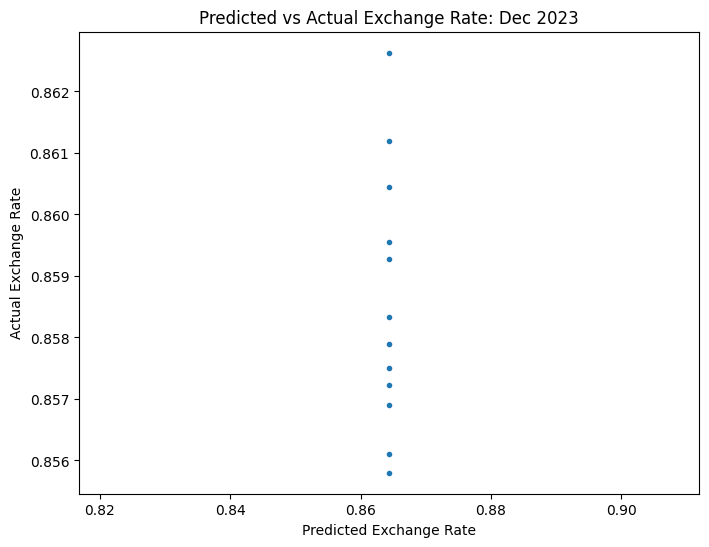

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(final_eval_12days['Predicted_Exchange_Rate'], final_eval_12days['Exchange_Rate'], label=False, marker=".")
plt.title("Predicted vs Actual Exchange Rate: Dec 2023")
plt.xlabel("Predicted Exchange Rate")   
plt.ylabel("Actual Exchange Rate")
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [ ]:
y_true = np.array(final_eval_12days['Exchange_Rate']) ##set the true values
y_pred = np.array(final_eval_12days['Predicted_Exchange_Rate']) ##set the predicted values

In [ ]:
mae = mean_absolute_error(y_true, y_pred) ##calculate the MAE
mse = mean_squared_error(y_true, y_pred) ##calculate the MSE

In [ ]:
print(f"Mean Absolute Error for December 2023 Predictions: {mae:.4f}") ##print the MAE
print(f"Mean Squared Error for December 2023 Predictions: {mse:.4f}") ##print the MSE

Mean Absolute Error for December 2023 Predictions: 0.0058
Mean Squared Error for December 2023 Predictions: 0.0000


In [ ]:
##calculate the MAPE
mape = np.abs((y_true - y_pred) / y_true).mean() * 100
print(f"Mean Absolute Percentage Error for December 2023 Predictions: {mape:.4f}%") ##print the MAPE

Mean Absolute Percentage Error for December 2023 Predictions: 0.6758%


**Conclusions** 

- We have analyzed historical exchange data from ECB to understand the fluctuations between the course of the EUR and the course of the Pound
- We have investigated the exchange rate and various levels (daily, monthly yearly) and provided an analysis of the exchange rate in relation to the GDP (Gross Domestic Product) of the UK
- We have used an ARIMA model and a Convolutional-GRU stacked model to make predictions of the EUR/GBP exchange rate : with the Convolutional-GRU model we obtained a mean absolute percentage error of 0.6758%, which is clearly inferior to the ARIMA model that has a MAPE of 0.2% for the first two weeks
- The ARIMA model is less sophisticated than the Convolutional-GRU but performs considerably better 